In [54]:
import numpy as np
import scipy.stats
import scipy.integrate as integrate
import quadrature_zi as qs
import quadrature_scikit as q
import matplotlib.pyplot as plt
from scipy.linalg import cholesky, cho_solve, solve_triangular
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


In [51]:
def flambda(x):
    return lambda x: x[1]*scipy.stats.norm(0, 1.0).pdf(x[0])
def normal(s):
    return scipy.stats.norm(0, 1.0).pdf(s)

def f(a):
    return -1.0* integrate.quad(lambda x: flambda(a)(x)*normal(x),np.NINF,np.inf)[0]

ftest = lambda x: [scipy.stats.norm(0, 1.0).pdf(x[1])*scipy.stats.norm(0, 1.0).pdf(x[0])]


In [58]:
X = np.random.normal(0,1,(20,2))
Y = np.apply_along_axis(normal, 1, X[:,1:])

In [59]:
kernel = RBF(1.0, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=9)
gp.fit(X,Y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1), n_restarts_optimizer=9,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [46]:
def integrate_dim(gp, sdim,a,b, B):
    length_scale = gp.kernel_.length_scale
    A = length_scale ** 2 * np.diag(np.ones(sdim))
    I = np.identity(sdim)

    X = gp.X_train_
    n, dim = X.shape
    z = np.zeros((n, 1))
    determ = np.linalg.det(np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    abinv = np.linalg.inv(A + B)
    for i in range(n):
        x = X[i, :sdim]
        xa = X[i, sdim:]
        expon = np.exp(-0.5 * np.dot(np.dot((x - b), abinv), (x - b).T))
        factor = np.exp(-0.5 * np.sum((xa-a)**2 / (length_scale ** 2)))
#         print factor * determ * expon
        z[i, :] = factor * determ * expon
    print z.shape, np.atleast_2d(gp.alpha_).shape
    mean = (z.T).dot(np.atleast_2d(gp.alpha_))
    var_determ = np.linalg.det(2 * np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    Kz = cho_solve((gp.L_, True), z)
    var = var_determ - np.dot(z.T, Kz)
    return mean, var

In [60]:
# qs.integrate_dim(gp, 1 ,np.array([0.0]),np.array([0.0]),np.array([[1.0]]))
print q.bqintegrate(gp,np.array([0.0,0.0]),np.array([[1.0,0.0],[0.0,1.0]]))

(array([[0.2835771]]), array([[2.96040981e-06]]), array([[0.82408808],
       [0.53164478],
       [0.79249429],
       [0.67145899],
       [0.61092636],
       [0.83936228],
       [0.75418856],
       [0.70230331],
       [0.72129266],
       [0.44364421],
       [0.62848984],
       [0.71400608],
       [0.71640157],
       [0.78921334],
       [0.52182893],
       [0.71258817],
       [0.70333853],
       [0.69082875],
       [0.74037285],
       [0.71224904]]))


In [49]:
x = np.atleast_2d(np.linspace(-10, 10, 10)).T
y_pred, sigma = gp.predict(x, return_std=True)
plt.clf()
fig = plt.figure()
# plt.plot(x, flambda(1.0)(x), 'r:', label=u'$f(x)$')
plt.plot(gp.X_train_, gp.y_train_, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
# plt.fill(np.concatenate([x, x[::-1]]),
#          np.concatenate([y_pred - 1.9600 * sigma,
#                         (y_pred + 1.9600 * sigma)[::-1]]),
#          alpha=.5, fc='b', ec='None')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0.0, 4.0)
plt.xlim(-3.5, 3.5)
plt.legend(loc='upper left')

ValueError: XA and XB must have the same number of columns (i.e. feature dimension.)

In [7]:
D = qs.OPT(ftest,50,1,1,(np.array([0.0]),np.array([[1.0]])))

/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00021225]), 'nit': 7, 'funcalls': 78}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.16890472]), 'nit': 7, 'funcalls': 93}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00025845]), 'nit': 10, 'funcalls': 92}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'wa

iter 0
[[1.11957722 1.07191664]
 [1.1189651  1.07191664]
 [1.13743445 1.07191664]
 [1.11557657 1.07191664]
 [1.1147796  1.07191664]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.02335787]), 'nit': 6, 'funcalls': 72}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([1.32322311e-05]), 'nit': 9, 'funcalls': 97}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00033295]), 'nit': 8, 'funcalls': 94}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'

iter 1
[[-0.15648299 -1.98300202]
 [-0.15368055 -1.98300202]
 [-0.16658663 -1.98300202]
 [-0.15142615 -1.98300202]
 [-0.1457725  -1.98300202]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.00066952]), 'nit': 7, 'funcalls': 75}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.00030908]), 'nit': 8, 'funcalls': 84}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.05272548]), 'nit': 5, 'funcalls': 84}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnf

iter 2
[[ 0.69538296 -0.45441895]
 [ 0.69662172 -0.45441895]
 [ 0.69695604 -0.45441895]
 [ 0.69928053 -0.45441895]
 [ 0.7028505  -0.45441895]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.04754323]), 'nit': 4, 'funcalls': 55}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00124401]), 'nit': 4, 'funcalls': 61}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.00388283]), 'nit': 10, 'funcalls': 107}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'wa

iter 3
[[ 2.16212162 -0.38910147]
 [ 2.16157392 -0.38910147]
 [ 2.16063284 -0.38910147]
 [ 2.19168712 -0.38910147]
 [ 2.14486551 -0.38910147]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00023222]), 'nit': 8, 'funcalls': 71}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00508296]), 'nit': 5, 'funcalls': 88}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00947309]), 'nit': 7, 'funcalls': 70}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'war

iter 4
[[-1.11782497  0.43904744]
 [-1.11773943  0.43904744]
 [-1.1175576   0.43904744]
 [-1.11715451  0.43904744]
 [-1.12841295  0.43904744]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.18478629]), 'nit': 4, 'funcalls': 59}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01224175]), 'nit': 8, 'funcalls': 87}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.00123042]), 'nit': 6, 'funcalls': 71}
  " state: %s" % convergence_dict)


iter 5
[[-0.5329815  -0.28423357]
 [-0.54840068 -0.28423357]
 [-0.52533814 -0.28423357]
 [-0.5500977  -0.28423357]
 [-0.55431167 -0.28423357]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-2.65836716e-05]), 'nit': 6, 'funcalls': 54}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00207427]), 'nit': 10, 'funcalls': 139}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.00833943]), 'nit': 5, 'funcalls': 65}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: 

iter 6
[[ 2.86377666 -0.12175186]
 [ 2.85830499 -0.12175186]
 [ 2.8563466  -0.12175186]
 [ 2.87494907 -0.12175186]
 [ 2.85098117 -0.12175186]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.00497818]), 'nit': 10, 'funcalls': 122}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00030494]), 'nit': 11, 'funcalls': 97}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.0077939]), 'nit': 7, 'funcalls': 81}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'wa

iter 7
[[-0.64596917  1.5408404 ]
 [-0.62832678  1.5408404 ]
 [-0.64831185  1.5408404 ]
 [-0.65249052  1.5408404 ]
 [-0.65840254  1.5408404 ]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.01000571]), 'nit': 8, 'funcalls': 110}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.0003835]), 'nit': 10, 'funcalls': 82}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([5.81145287e-05]), 'nit': 7, 'funcalls': 76}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'w

iter 8
[[-2.60562275 -0.04900978]
 [-2.60697512 -0.04900978]
 [-2.60801701 -0.04900978]
 [-2.60071066 -0.04900978]
 [-2.61286403 -0.04900978]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.06714678]), 'nit': 7, 'funcalls': 83}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([1.28746033e-05]), 'nit': 10, 'funcalls': 90}
  " state: %s" % convergence_dict)


iter 9
[[ 1.29558464 -0.06466159]
 [ 1.30956387 -0.06466159]
 [ 1.28853204 -0.06466159]
 [ 1.28260405 -0.06466159]
 [ 1.31953581 -0.06466159]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.3936899]), 'nit': 6, 'funcalls': 67}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.26079151]), 'nit': 8, 'funcalls': 95}
  " state: %s" % convergence_dict)


iter 10
[[-0.70829935  0.08525851]
 [-0.73502137  0.08525851]
 [-0.70390382  0.08525851]
 [-0.70107512  0.08525851]
 [-0.69936521  0.08525851]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00054193]), 'nit': 9, 'funcalls': 99}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-19.2052424]), 'nit': 4, 'funcalls': 51}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00041664]), 'nit': 9, 'funcalls': 88}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'war

iter 11
[[ 0.15030096 -0.01242674]
 [ 0.15181134 -0.01242674]
 [ 0.14804436 -0.01242674]
 [ 0.14808592 -0.01242674]
 [ 0.1571597  -0.01242674]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.00680852]), 'nit': 4, 'funcalls': 62}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01025105]), 'nit': 7, 'funcalls': 78}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.09382915]), 'nit': 6, 'funcalls': 86}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnf

iter 12
[[2.99848025 0.02130388]
 [2.98696861 0.02130388]
 [2.98166066 0.02130388]
 [2.97991822 0.02130388]
 [2.96080851 0.02130388]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.02543032]), 'nit': 9, 'funcalls': 73}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.26056993]), 'nit': 5, 'funcalls': 62}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00243735]), 'nit': 6, 'funcalls': 56}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'war

iter 13
[[-1.53378495 -0.04406175]
 [-1.52664417 -0.04406175]
 [-1.54639653 -0.04406175]
 [-1.5247919  -0.04406175]
 [-1.5501523  -0.04406175]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.00927234]), 'nit': 8, 'funcalls': 74}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.09908319]), 'nit': 10, 'funcalls': 104}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01611876]), 'nit': 5, 'funcalls': 67}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'wa

iter 14
[[ 8.31953757e-01 -1.03092908e-04]
 [ 8.33515810e-01 -1.03092908e-04]
 [ 8.52725032e-01 -1.03092908e-04]
 [ 8.27284973e-01 -1.03092908e-04]
 [ 8.23306529e-01 -1.03092908e-04]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.39318907]), 'nit': 7, 'funcalls': 103}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00228453]), 'nit': 8, 'funcalls': 89}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00107825]), 'nit': 7, 'funcalls': 86}
  " state: %s" % convergence_dict)


iter 15
[[-0.09460093 -0.03470727]
 [-0.11535886 -0.03470727]
 [-0.08379116 -0.03470727]
 [-0.09455191 -0.03470727]
 [-0.08161573 -0.03470727]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.05693293]), 'nit': 9, 'funcalls': 93}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-3.76701355e-05]), 'nit': 6, 'funcalls': 56}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.03845596]), 'nit': 5, 'funcalls': 56}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'w

iter 16
[[-0.93861685 -0.032982  ]
 [-0.94596754 -0.032982  ]
 [-0.94132972 -0.032982  ]
 [-0.95025474 -0.032982  ]
 [-0.9252213  -0.032982  ]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.04694891]), 'nit': 4, 'funcalls': 53}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01470566]), 'nit': 8, 'funcalls': 80}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.00087452]), 'nit': 7, 'funcalls': 61}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warn

iter 17
[[ 2.85559600e+00 -1.69971642e-03]
 [ 2.84865212e+00 -1.69971642e-03]
 [ 2.84545797e+00 -1.69971642e-03]
 [ 2.84111601e+00 -1.69971642e-03]
 [ 2.83725621e+00 -1.69971642e-03]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.06213021]), 'nit': 6, 'funcalls': 70}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.42670012]), 'nit': 6, 'funcalls': 68}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.36093779]), 'nit': 7, 'funcalls': 89}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'war

iter 18
[[-2.7948739   0.11187522]
 [-2.78492052  0.11187522]
 [-2.78213169  0.11187522]
 [-2.80196391  0.11187522]
 [-2.80612728  0.11187522]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00060129]), 'nit': 8, 'funcalls': 59}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.06728542]), 'nit': 3, 'funcalls': 53}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.01186883]), 'nit': 9, 'funcalls': 110}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warn

iter 19
[[2.31251333e+00 5.73526769e-04]
 [2.30522616e+00 5.73526769e-04]
 [2.30583138e+00 5.73526769e-04]
 [2.33388689e+00 5.73526769e-04]
 [2.33777111e+00 5.73526769e-04]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.07036984]), 'nit': 4, 'funcalls': 53}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.00740743]), 'nit': 7, 'funcalls': 77}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00038636]), 'nit': 9, 'funcalls': 73}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warn

iter 20
[[0.10348271 0.00568504]
 [0.09223632 0.00568504]
 [0.07462975 0.00568504]
 [0.12444024 0.00568504]
 [0.08973399 0.00568504]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00117874]), 'nit': 7, 'funcalls': 63}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00528336]), 'nit': 7, 'funcalls': 84}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00772381]), 'nit': 7, 'funcalls': 74}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'war

iter 21
[[ 0.73871498 -0.07679663]
 [ 0.73382094 -0.07679663]
 [ 0.72276154 -0.07679663]
 [ 0.71964998 -0.07679663]
 [ 0.72126838 -0.07679663]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.29032727]), 'nit': 8, 'funcalls': 67}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.19875362]), 'nit': 6, 'funcalls': 72}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00779077]), 'nit': 8, 'funcalls': 94}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warn

iter 22
[[1.3860612  0.08298132]
 [1.3919098  0.08298132]
 [1.38418496 0.08298132]
 [1.40100104 0.08298132]
 [1.3790804  0.08298132]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.1271165]), 'nit': 6, 'funcalls': 74}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.07311893]), 'nit': 7, 'funcalls': 88}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00165522]), 'nit': 11, 'funcalls': 121}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warn

iter 23
[[-4.57619207e-01 -4.06310701e-04]
 [-4.40034712e-01 -4.06310701e-04]
 [-4.65072107e-01 -4.06310701e-04]
 [-4.60654043e-01 -4.06310701e-04]
 [-4.33469502e-01 -4.06310701e-04]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.16260004]), 'nit': 6, 'funcalls': 59}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00091648]), 'nit': 7, 'funcalls': 67}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01986027]), 'nit': 7, 'funcalls': 93}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'war

iter 24
[[ 0.25204317 -0.0487637 ]
 [ 0.21946106 -0.0487637 ]
 [ 0.25827592 -0.0487637 ]
 [ 0.21292263 -0.0487637 ]
 [ 0.23673527 -0.0487637 ]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.08455837]), 'nit': 5, 'funcalls': 52}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00321633]), 'nit': 5, 'funcalls': 60}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00053906]), 'nit': 7, 'funcalls': 73}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'war

iter 25
[[ 2.9994395  -0.0288654 ]
 [ 2.9993589  -0.0288654 ]
 [ 2.99511622 -0.0288654 ]
 [ 2.9949294  -0.0288654 ]
 [-0.74526412 -0.0288654 ]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01854706]), 'nit': 6, 'funcalls': 79}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.00110626]), 'nit': 9, 'funcalls': 76}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-4.00543213e-05]), 'nit': 7, 'funcalls': 65}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'

iter 26
[[0.39371347 0.02529765]
 [0.41148996 0.02529765]
 [0.39796203 0.02529765]
 [0.40722621 0.02529765]
 [0.35651685 0.02529765]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.14344656]), 'nit': 6, 'funcalls': 56}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00339699]), 'nit': 4, 'funcalls': 57}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00528347]), 'nit': 6, 'funcalls': 59}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'war

iter 27
[[-0.57537219  0.00955359]
 [-0.52730149  0.00955359]
 [-0.58604537  0.00955359]
 [-0.52607012  0.00955359]
 [-0.58665547  0.00955359]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.00089633]), 'nit': 8, 'funcalls': 86}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.04636231]), 'nit': 6, 'funcalls': 64}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.05890763]), 'nit': 5, 'funcalls': 54}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warn

iter 28
[[-1.55026137 -0.00163867]
 [-1.52622111 -0.00163867]
 [-1.53375919 -0.00163867]
 [-1.51816463 -0.00163867]
 [-1.53452723 -0.00163867]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.10804856]), 'nit': 5, 'funcalls': 57}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.00108886]), 'nit': 8, 'funcalls': 96}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.0028075]), 'nit': 8, 'funcalls': 84}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnfl

iter 29
[[0.46994355 0.06254616]
 [0.47407433 0.06254616]
 [0.48909912 0.06254616]
 [0.48337027 0.06254616]
 [0.45214212 0.06254616]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00057682]), 'nit': 10, 'funcalls': 82}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01368704]), 'nit': 7, 'funcalls': 72}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00913253]), 'nit': 6, 'funcalls': 68}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'wa

iter 30
[[-0.5004566   0.01133339]
 [-0.44459923  0.01133339]
 [-0.46083513  0.01133339]
 [-0.52552002  0.01133339]
 [-0.4051809   0.01133339]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00063539]), 'nit': 6, 'funcalls': 76}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.45653462]), 'nit': 6, 'funcalls': 74}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01751924]), 'nit': 4, 'funcalls': 70}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'war

iter 31
[[ 1.26274828 -0.0070041 ]
 [ 1.25241619 -0.0070041 ]
 [ 1.23223017 -0.0070041 ]
 [ 1.27909984 -0.0070041 ]
 [ 1.24415771 -0.0070041 ]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.59256107]), 'nit': 5, 'funcalls': 61}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00046611]), 'nit': 7, 'funcalls': 76}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.40354788]), 'nit': 6, 'funcalls': 59}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'war

iter 32
[[-0.91912579 -0.01106737]
 [-0.92830534 -0.01106737]
 [-0.89282058 -0.01106737]
 [-0.8892365  -0.01106737]
 [-0.96152848 -0.01106737]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.06629372]), 'nit': 7, 'funcalls': 124}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.00092411]), 'nit': 9, 'funcalls': 73}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.0979073]), 'nit': 3, 'funcalls': 58}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnf

iter 33
[[ 0.05452128 -0.00979865]
 [ 0.04793505 -0.00979865]
 [ 0.02719493 -0.00979865]
 [ 0.03511747 -0.00979865]
 [ 0.02587374 -0.00979865]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.42504123]), 'nit': 6, 'funcalls': 54}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00047114]), 'nit': 7, 'funcalls': 69}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.0098325]), 'nit': 9, 'funcalls': 91}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warn

iter 34
[[-2.99472442 -0.01338021]
 [-2.99819858 -0.01338021]
 [-2.99725117 -0.01338021]
 [-2.98103852 -0.01338021]
 [-2.97952292 -0.01338021]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00242814]), 'nit': 6, 'funcalls': 70}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01333475]), 'nit': 7, 'funcalls': 73}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00109318]), 'nit': 8, 'funcalls': 77}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'war

iter 35
[[-2.19054876 -0.00475156]
 [-2.19300711 -0.00475156]
 [-2.21244152 -0.00475156]
 [-2.15926268 -0.00475156]
 [-2.17656901 -0.00475156]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.07830644]), 'nit': 9, 'funcalls': 118}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.0589236]), 'nit': 5, 'funcalls': 52}
  " state: %s" % convergence_dict)


iter 36
[[2.51929503 0.00342338]
 [2.49410549 0.00342338]
 [2.52497366 0.00342338]
 [2.51400628 0.00342338]
 [2.53553832 0.00342338]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01267946]), 'nit': 5, 'funcalls': 74}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([5.22136688e-05]), 'nit': 8, 'funcalls': 74}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00143719]), 'nit': 6, 'funcalls': 57}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'

iter 37
[[ 0.34458132 -0.05559836]
 [ 0.33455731 -0.05559836]
 [ 0.34177326 -0.05559836]
 [ 0.3761576  -0.05559836]
 [ 0.32394156 -0.05559836]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00658083]), 'nit': 6, 'funcalls': 75}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.24284267]), 'nit': 6, 'funcalls': 68}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.09188366]), 'nit': 8, 'funcalls': 92}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'war

iter 38
[[-1.06158358  0.00691671]
 [-1.08693816  0.00691671]
 [-1.08607766  0.00691671]
 [-1.04282926  0.00691671]
 [-1.06911269  0.00691671]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.00047421]), 'nit': 7, 'funcalls': 73}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([5.48362732e-05]), 'nit': 9, 'funcalls': 92}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00043797]), 'nit': 8, 'funcalls': 78}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'w

iter 39
[[-0.03734899  0.02751532]
 [-0.08146546  0.02751532]
 [ 0.00181692  0.02751532]
 [-0.08063231  0.02751532]
 [-0.07833567  0.02751532]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.17563343]), 'nit': 4, 'funcalls': 50}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.33633566]), 'nit': 8, 'funcalls': 74}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00610209]), 'nit': 6, 'funcalls': 65}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'war

iter 40
[[ 1.29254318 -0.03080603]
 [ 1.25002662 -0.03080603]
 [ 1.29633728 -0.03080603]
 [ 1.29520996 -0.03080603]
 [ 1.23374491 -0.03080603]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.00760019]), 'nit': 9, 'funcalls': 88}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01335484]), 'nit': 6, 'funcalls': 75}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.50170022]), 'nit': 6, 'funcalls': 75}
  " state: %s" % convergence_dict)


iter 41
[[-0.97186153 -0.00532779]
 [-0.93375343 -0.00532779]
 [-0.95062183 -0.00532779]
 [-0.94709063 -0.00532779]
 [-0.93302592 -0.00532779]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.93216779]), 'nit': 3, 'funcalls': 53}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.15019231]), 'nit': 5, 'funcalls': 59}
  " state: %s" % convergence_dict)


iter 42
[[1.05965548 0.00931638]
 [1.08398732 0.00931638]
 [1.04646284 0.00931638]
 [1.10979407 0.00931638]
 [0.99897209 0.00931638]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.00132528]), 'nit': 9, 'funcalls': 81}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.01303014]), 'nit': 5, 'funcalls': 61}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00311959]), 'nit': 9, 'funcalls': 97}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnf

iter 43
[[ 0.0752525  -0.00558364]
 [ 0.08923425 -0.00558364]
 [ 0.04873811 -0.00558364]
 [ 0.02864478 -0.00558364]
 [ 0.10410927 -0.00558364]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.0071218]), 'nit': 7, 'funcalls': 103}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01009846]), 'nit': 7, 'funcalls': 78}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00248384]), 'nit': 9, 'funcalls': 114}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'wa

iter 44
[[0.06943236 0.00181088]
 [0.11907344 0.00181088]
 [0.15289602 0.00181088]
 [0.00997293 0.00181088]
 [0.09245698 0.00181088]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.15767312]), 'nit': 4, 'funcalls': 50}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.1656785]), 'nit': 4, 'funcalls': 57}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01819992]), 'nit': 9, 'funcalls': 80}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warn

iter 45
[[-0.82182728  0.01708377]
 [-0.86302382  0.01708377]
 [-0.93522381  0.01708377]
 [-0.87767285  0.01708377]
 [-0.76193664  0.01708377]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00915325]), 'nit': 5, 'funcalls': 73}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-70.72160137]), 'nit': 4, 'funcalls': 102}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01725876]), 'nit': 6, 'funcalls': 86}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'w

iter 46
[[0.0272591  0.00561843]
 [0.06182154 0.00561843]
 [0.13700239 0.00561843]
 [0.04397699 0.00561843]
 [0.12829115 0.00561843]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.00105554]), 'nit': 5, 'funcalls': 60}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00071764]), 'nit': 7, 'funcalls': 79}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.02689856]), 'nit': 6, 'funcalls': 66}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warn

iter 47
[[0.98725228 0.02010449]
 [0.91281175 0.02010449]
 [0.99250085 0.02010449]
 [1.00918413 0.02010449]
 [0.93102157 0.02010449]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.11063552]), 'nit': 4, 'funcalls': 50}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.28417754]), 'nit': 6, 'funcalls': 83}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.08110893]), 'nit': 5, 'funcalls': 69}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'war

iter 48
[[-0.91034591 -0.00610327]
 [ 1.23639247 -0.00610327]
 [-0.83743149 -0.00610327]
 [-0.92441    -0.00610327]
 [-0.96975288 -0.00610327]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([4.8995018e-05]), 'nit': 5, 'funcalls': 51}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([0.17211413]), 'nit': 8, 'funcalls': 134}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.0001924]), 'nit': 11, 'funcalls': 128}
  " state: %s" % convergence_dict)


iter 49
[[ 0.10389836 -0.00476664]
 [ 0.16109094 -0.00476664]
 [ 0.18478424 -0.00476664]
 [ 0.08036626 -0.00476664]
 [ 0.17551171 -0.00476664]]


/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.05321002]), 'nit': 4, 'funcalls': 50}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01328301]), 'nit': 7, 'funcalls': 71}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.3303864]), 'nit': 4, 'funcalls': 57}
  " state: %s" % convergence_dict)
/Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warn

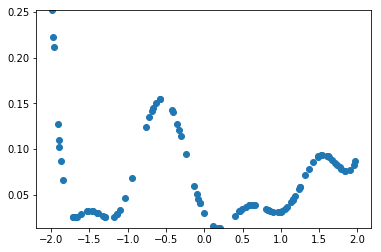

In [35]:
import numpy as np
import matplotlib.pyplot as plt
i = 1
y = 2
plt.clf()
plt.scatter(D[i][0], D[i][y])
plt.ylim(D[i][y].min(),D[i][y].max())
plt.show()

In [22]:
D[3][2].max()

2.2457480430837506e-08

In [14]:
np.repeat(np.reshape(maxa,(1,-1)),10,axis=0).shape

(10,)